In [19]:
import numpy as np
from collections import defaultdict, OrderedDict
from tqdm import tqdm
from PIL import Image
import os
import pickle
import IPython.core.debugger as pdb
from IPython.display import SVG
from random import shuffle

## Utils

In [2]:
def load_all_imgs(files, img_size):
    """Loads all facades images
    """
    a_list = []
    b_list = []
    for fn in files:
        img_arr = np.array(Image.open(fn))
        a_list.append(img_arr[:, :img_size])
        b_list.append(img_arr[:, img_size:])
    return np.array(a_list), np.array(b_list)

In [3]:
data_path = '/Users/stephanrasp/repositories/CGAN-towards-CBRAIN/datasets/facades/train/'

## Models

In [4]:
from keras.models import Model
from keras.layers import *
import keras.backend as K
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [5]:
K.set_image_data_format('channels_last')

In [6]:
assert K.image_data_format() == 'channels_last', 'Require channels_last!'

In [7]:
def conv_block(x, filters, bn=True):
    """
    Convolution block: Conv2D -> Batch norm -> LeakyReLU

    Args:
        x: Input tensor [samples, channels/filters, height, width]
        filters: Number of output filters
        bn: Use batch norm

    Returns:
        x: Output tensor [samples, filters, height, width]
    """
    x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
    if bn:
        x = BatchNormalization(axis=-1)(x)   # Channel axis
    x = LeakyReLU(0.2)(x)
    return x

In [8]:
def upsample_block(x, x_down, filters, bn=True, dr=0.5):
    """
    Upsampling block for Unet

    Args:
        x:
        filters:
        bn:
        dr:

    Returns:
        x:
    """
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    if bn:
        x = BatchNormalization(axis=-1)(x)
    if dr > 0:
        x = Dropout(dr)(x)
    return concatenate([x, x_down], axis=-1)   # Concatenate along channel axis

In [9]:
def create_Unet_generator(img_dim, n_down, n_filters_first=64, final_activation='tanh'):
    """
    Create the generator model: Unet
    For now only 3 channels to 3 channels.
    """

    # Define input
    inp = Input(shape=img_dim)
    x = inp

    # Go down
    down_list = []
    
    # Look at that
    filter_list = [n_filters_first * min(8, (2 ** i)) for i in range(n_down)]
    print(filter_list)
    for n, n_filters in enumerate(filter_list):
        #pdb.set_trace()
        x = conv_block(x, n_filters)
        down_list.append(x)
    
    # Go up
    for x_down, n_filters in zip(down_list[:-1][::-1], filter_list[:-1][::-1]):
        x = upsample_block(x, x_down, n_filters)

    # Final upsampling and activation
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(3, kernel_size=3, padding='same')(x)
    outp = Activation(final_activation)(x)

    # Create and return model
    return Model(inputs=inp, outputs=outp)

In [10]:
def create_PixelGAN_discriminator(img_dim, n_filters_first=64, n_layers=3):
    """
    Create the discriminator model: PixelGAN

    Args:
        img_dim: Tuple of image dimensions [channels, height, width]
        n_filters_first: Number of convolution filters in the first layer
        n_layers: number of convolution layers including first

    Returns:
        model: Keras model
    """

    # Get input tensor
    inp = Input(shape=img_dim)

    # First convolution layer
    x = conv_block(inp, n_filters_first, bn=False)   # False in pytorch implentation

    # Loop over next layers
    n_filters = n_filters_first
    for n in range(1, n_layers):
        x = conv_block(x, n_filters)
        n_filters = min(2**n, 8) * n_filters_first

    # Final layer to scalar
    outp = Dense(1, activation='sigmoid')(Flatten()(x))

    # Create and return model
    return Model(inputs=inp, outputs=outp)

### Test

In [11]:
G = create_Unet_generator((256, 256, 3), 3)

[64, 128, 256]


In [12]:
G.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

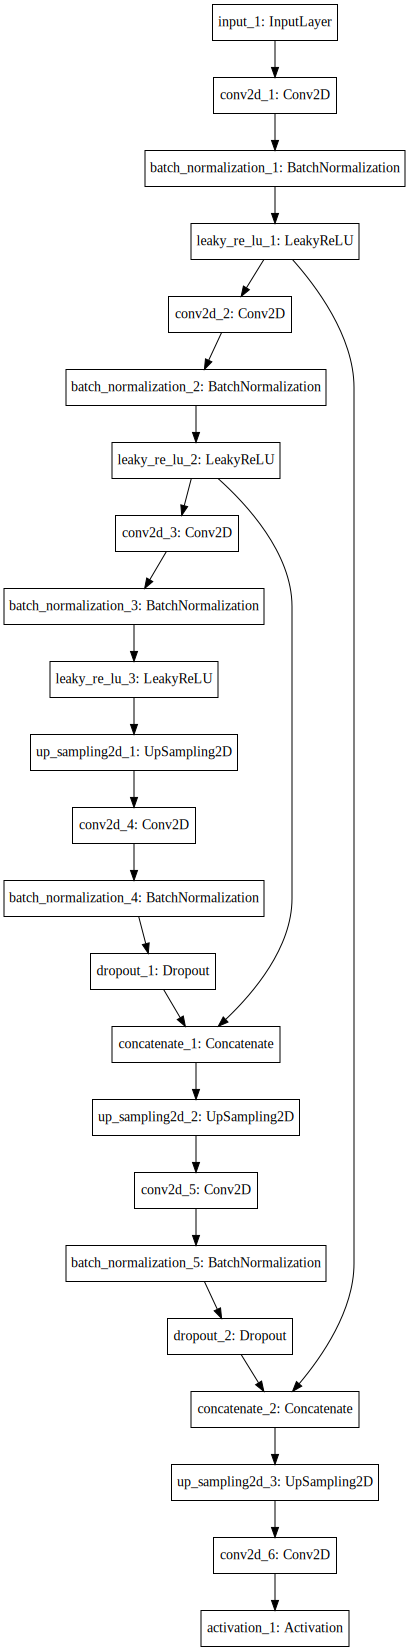

In [13]:
SVG(model_to_dot(G).create(prog='dot', format='svg'))

In [14]:
D = create_PixelGAN_discriminator((256, 256, 3))

In [15]:
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       73856     
__________

## Data generator

In [20]:
import threading
from glob import glob


# To make generators thread safe for multithreading
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return ThreadsafeIter(f(*a, **kw))
    return g


class ThreadsafeIter(object):
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    https://github.com/fchollet/keras/issues/1638
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):   # Py3
        with self.lock:
            return next(self.it)


def generator(a_imgs, b_imgs, bs, n_batches, shuffle=False):
    """First basic generator to work with facades dataset.
    """
    while True:
        for i in range(n_batches):
            x = a_imgs[i*bs:(i+1)*bs]
            y = b_imgs[i*bs:(i+1)*bs]
            yield x, y


class DataGenerator(object):
    def __init__(self, files, img_size=256, bs=4):
        self.files = files #sorted(glob(data_dir + '*'))
        self.a_imgs, self.b_imgs = load_all_imgs(self.files, img_size)
        self.bs = bs
        self.n_samples = self.a_imgs.shape[0]
        self.n_batches = int(np.floor(self.n_samples / bs))
        self.gen = generator(self.a_imgs, self.b_imgs, bs, self.n_batches)

## GAN

In [18]:
def load_all_imgs(files, img_size):
    """Loads all facades images
    """
    a_list = []
    b_list = []
    for fn in files:
        img_arr = np.array(Image.open(fn))
        a_list.append(img_arr[:, :img_size])
        b_list.append(img_arr[:, img_size:])
    return np.array(a_list), np.array(b_list)

In [21]:
def l1_loss(y_true, y_pred):
    return K.sum(K.abs(y_pred - y_true), axis=-1)

In [16]:
class GAN(object):
    """
    GAN class.
    """
    def __init__(self):
        """
        Initialize GAN object. Define attributes.

        Args:
            verbose: Verbosity level
        """
        # Initialize empty networks
        self.G = None    # Generator G(x)
        self.D = None    # Discriminator D(x)
        self.GD = None   # Combined D(G(x))

        # Initialize the data generators
        # Generators should be compatible to CBRAIN data generator
        self.train_generator=None
        self.valid_generator=None

        # Define basic properties of the network
        self.image_dim = (256, 256, 3)
        
        # Training information
        # Useful if training is not done in one go
        self.epoch_counter = 0
        self.train_history = OrderedDict({
            'train_discriminator_loss': [],
            'train_generator_loss': [],
            'valid_discriminator_loss': [],
            'valid_generator_loss': [],
        })
        self.verbose = verbose

    def create_generator(self, **kwargs):
        """
        Create the generator network.
        """
        self.G = create_Unet_generator(**kwargs)

    def create_discriminator(self, **kwargs):
        """
        Create the discriminator network
        """
        self.D = create_PixelGAN_discriminator(**kwargs)

    def compile(self, loss_weights=[10, 1]):
        """
        Compile the networks and create the combined network.
        """
        opt = Adam(1e-3)
        # Compile the individual models
        self.G.compile(optimizer=opt, loss='mse')  # Loss does not matter for G
        self.D.compile(optimizer=opt, loss='binary_crossentropy')

        # Create and compile the combined model
        self.D.trainable = False
        G_inp = Input(shape=(self.image_dim,))
        G_outp = self.G(G_inp)
        D_outp = self.D(self.G(G_inp))
        self.GD = Model(inputs=G_inp, outputs=[G_outp, D_outp])
        self.GD.compile(optimizer=opt, loss=[l1_loss, 'binary_crossentropy'])

    def load_data_generator(self, data_dir, bs, valid_frac=0.2, **kwargs):
        """
        Load the training and validation data generators for the requested
        dataset.

        Args:
            dataset: Name of dataset
            bs: Batch size
        """
        files = sorted(glob(data_path + '*'))
        shuffle(files)
        split_idx = int(len(files) * valid_frac)
        self.train_generator = DataGenerator(data_dir, files[split_idx:])
        self.valid_generator = DataGenerator(data_dir, files[:split_idx])

    def train(self, epochs):
        """
        Training operation. Note that batch size is defined in the data
        generator.

        Args:
            epochs: Number of epochs to train
        """

        if self.verbose > 0: pbar = tqdm(total=epochs * n_batches)
        for e in range(self.epoch_counter, self.epoch_counter + epochs):
            dl, gl = [], []
            for b in range(n_batches):
                if self.verbose > 0: pbar.update(1)
                dl, gl = self.train_step(bs, dl, gl, train_D_separately,
                                         noise_shape, n_disc)
            self.epoch_counter += 1

            # End of epoch. Compute mean generator and discriminator loss
            self.train_history['train_discriminator_loss'].append(np.mean(dl))
            self.train_history['train_generator_loss'].append(np.mean(gl))
            fake = self.evaluate_test_losses(noise_shape, bs)

            # Save images
            if e % save_interval == 0:
                self.save_images(fake)

            # Update progressbar with latest losses
            if self.verbose > 0:
                pbar_dict = OrderedDict({k: v[-1] for k, v
                                         in self.train_history.items()})
                pbar.set_postfix(pbar_dict)
        if self.verbose > 0: pbar.close()

    def train_step(self, bs, dl, gl, train_D_separately, noise_shape,
                   n_disc):
        """One training step. May contain several discriminator steps."""

        # STEP 1: TRAIN DISCRIMINATOR
        self.D.trainable = True

        # Get images
        X, Y = next(self.train_generator.gen())

        # Create fake images
        fake = self.G.predict_on_batch(X)

        # Concatenate real and fake images and train the discriminator
        X_concat = np.concatenate([real, fake])
        y_concat = np.array(
            self.label('real') * bs + self.label('fake') * bs
        )
        dl.append(self.D.train_on_batch(X_concat, y_concat))


        # STEP 2: TRAIN GENERATOR
        self.D.trainable = False
        gl.append(self.GD.train_on_batch())
        return dl, gl

    def evaluate_test_losses(self, noise_shape, bs):
        """Compute losses for test set and returns some fake images"""
        fake = self.G.predict()
        X_concat = np.concatenate([self.X_test, fake])
        y_concat = np.array(
            self.label('real') * self.n_test +
            self.label('fake') * self.n_test
        )
        self.train_history['test_discriminator_loss'].append(
            self.D.evaluate(X_concat, y_concat, batch_size=bs, verbose=0)
        )
        self.train_history['test_generator_loss'].append(
            self.GD.evaluate())
        return fake

    def label(self, s):
        """Little helper function to return labels"""
        assert s in ['real', 'fake'], 'Wrong string for label function.'
        return [1] if s == 'real' else [0]

    def save_images(self, fake):
        """Saves some fake images"""
        s = (self.img_dir + '/' + self.exp_id + '_' +
               'plot_epoch_{0:04d}_generated'.format(self.epoch_counter))
        if self.dataset == 'mnist':
            # From https://github.com/lukedeo/keras-acgan/blob/master/mnist_acgan.py
            img = (np.concatenate(
                [fake[i * 3:(i + 1) * 3, :, :, 0].reshape(-1, self.image_size)
                 for i in range(3)],
                axis=-1
            ) * 127.5 + 127.5).astype(np.uint8)
            Image.fromarray(img).save(s + '.png')
        if self.dataset == 'radar':
            np.save(s + '.npy', fake[:9])

    def save_models(self):
        """
        Saves models and training history
        """
        s = self.model_dir + self.exp_id + '_'
        self.G.save(s + 'G.h5')
        self.D.save(s + 'D.h5')
        self.GD.save(s + 'GD.h5')
        # Save training history
        with open(s + 'history.pkl', 'wb') as f:
            pickle.dump(self.train_history, f)